Taking the Data from Yahoo Finance 

# SIMPLE MOVING AVERAGE 

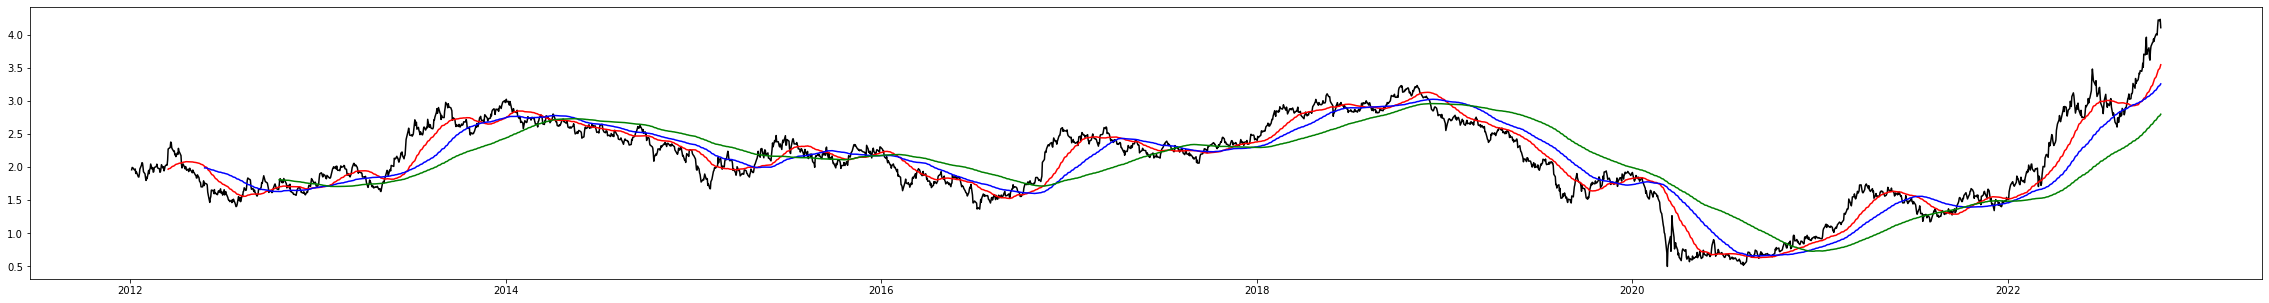

In [1]:
import datetime as dt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


ticker = '^TNX'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,10,25)

history = web.DataReader(ticker, 'yahoo', start=start, end=end)
history = history.loc[:, ['Open', 'Close']]
history.head()



history['Previous_Close'] = history.loc[:, 'Close'].shift(1)  #First Indicator 
# display(history)

datetimes = history.index.values #Second Indicator 
weekdays = []

for dt in datetimes:
    dt = datetime.strptime(str(dt), '%Y-%m-%dT%H:%M:%S.000000000')
    weekdays.append(dt.weekday())


history['Weekday'] = weekdays

history['50SMA'] = history['Previous_Close'].rolling(50).mean()
history['100SMA'] = history['Previous_Close'].rolling(100).mean()
history['200SMA'] = history['Previous_Close'].rolling(200).mean()


x = history.index.values # X values is the overall time 


plt.figure(figsize=(40,5))
plt.plot(x, history['Previous_Close'], color = 'black')
plt.plot(x, history['50SMA'], color = 'red')
plt.plot(x, history['100SMA'], color = 'blue')
plt.plot(x, history['200SMA'], color = 'green')


# if red is below the green line: short term we are going to be negative while long term is stil positive (T BOND IS trending downwards). VISE VERSA 

## MCD Method

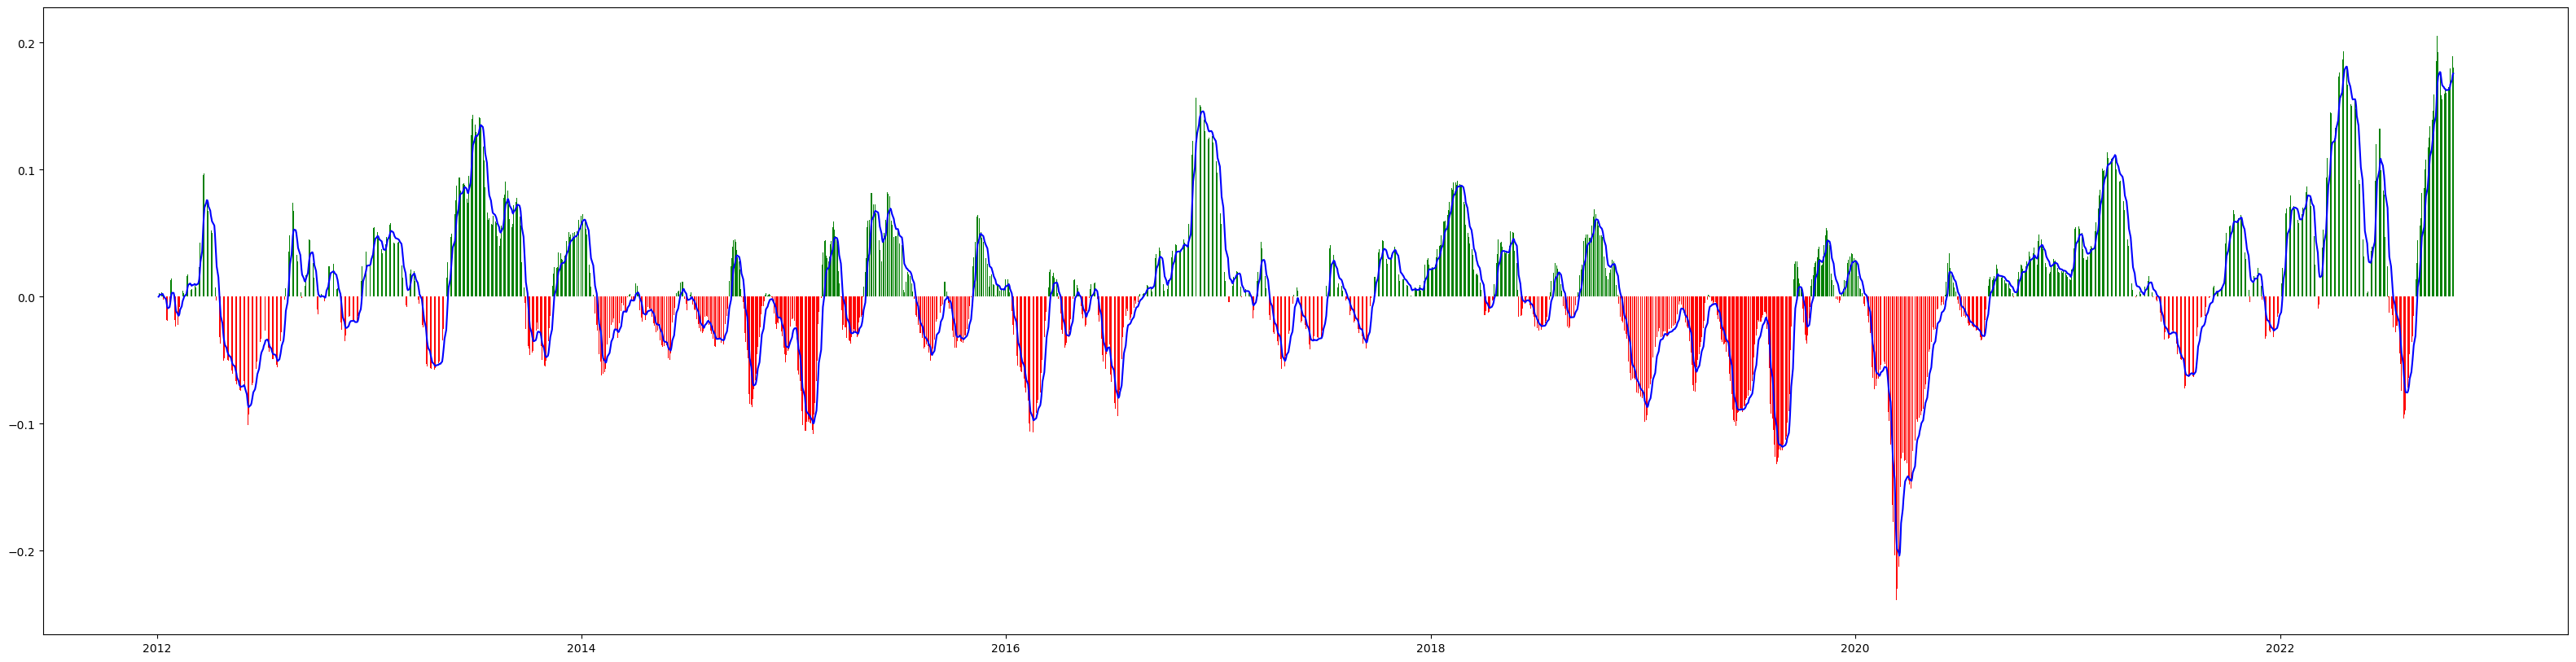

In [2]:
def calc_macd(data, len1, len2, len3):   ### Moving average but with exponential 
    shortEMA = data.ewm(span = len1, adjust =False).mean()
    longEMA = data.ewm(span = len2, adjust= False).mean()
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span = len3, adjust= False).mean()
    return MACD, signal


MACD, signal = calc_macd(history['Previous_Close'], 12, 26 , 9) ### Need to check on the numbers here 
history['MACD'] = MACD
history['MACD_signal'] = signal

x = history.index.values # X values is the overall time 

plt.figure(figsize=(40,10))

colors = np.array(['green'] * len(history['MACD']))
colors[history['MACD'] < 0 ] = 'red'
plt.bar(x, history.MACD, color= colors)
plt.plot(x, history.MACD_signal, color= 'blue')
plt.show()

# BOLLINGER METHOD, CALCULATING THE MAXIMUM AND MINIMUM POINT

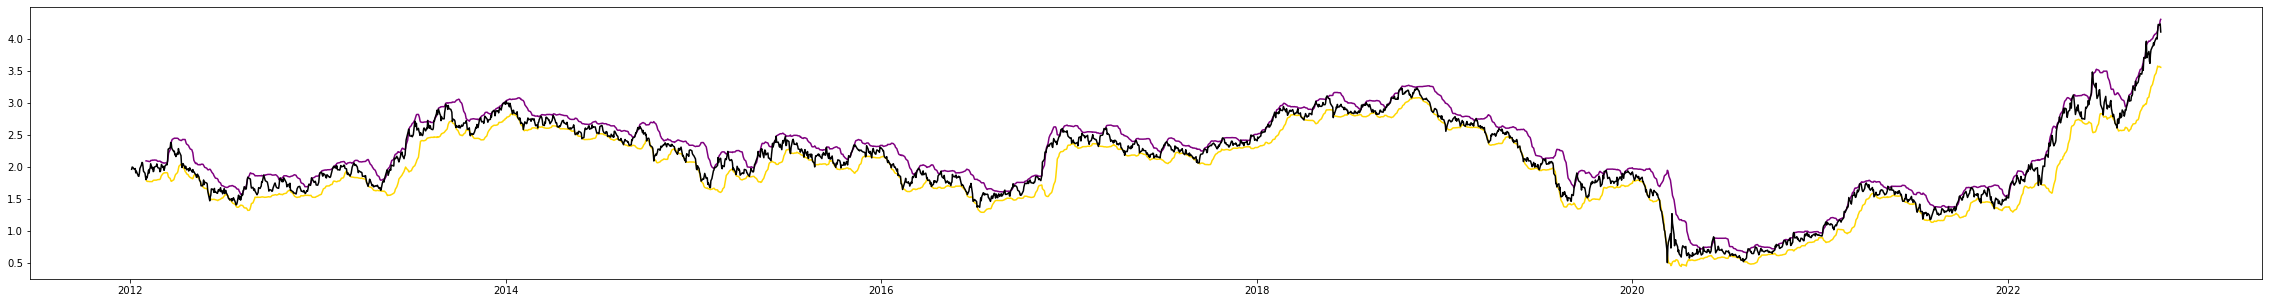

In [2]:
def calc_bollinger(data, period):
    mean = data.rolling(period).mean()
    SD = data.rolling(period).std()
    upper_band = np.array(mean) + 2 * np.array(SD)
    lower_band = np.array(mean) - 2 * np.array(SD)
    return upper_band, lower_band


upper, lower = calc_bollinger(history['Previous_Close'], 20) ##We can play around the number. THe number is days lookback (need to check)
history['Upper_Band'] = upper
history['Lower_Band'] = lower 

x = history.index.values # X values is the overall time 

plt.figure(figsize=(40,5))
plt.plot(x, history['Upper_Band'], color = 'purple') #Max
plt.plot(x, history['Lower_Band'], color = 'gold')  #Min


plt.plot(x, history['Previous_Close'], color = 'black')




plt.show()

## Linear Regression

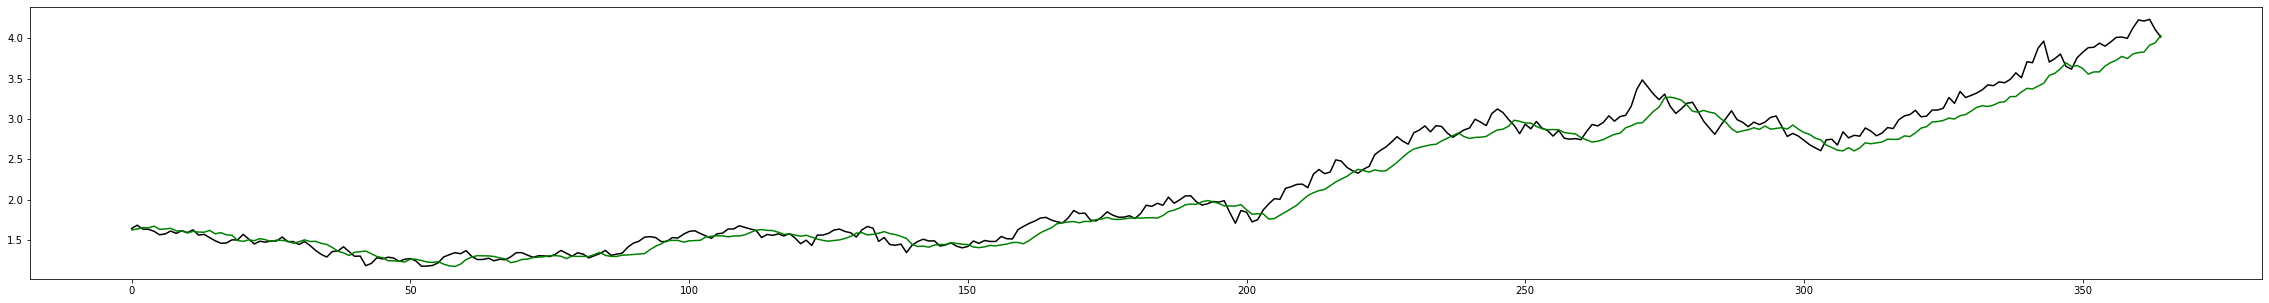

In [86]:
from sklearn.linear_model import LinearRegression

#Preparing the Data from Previous Session 

history = history.replace(np.inf, np.nan).dropna() #Replacing infinite values to NA, and then dropping all NA. 
#Linear Regression will not take NA values kindly 



y = history['Close'] #The value that we wants to predict
x = history.drop('Close', axis = 1 ) #Dropping the Close since this is the value that we wants to predict


# Split the Data to Train and Test 

number_day_test = 365  # we want to get the 1 year of data 
predict_offset = 1
consecutive_feature_days = 7

idx_train = list(range(len(x)))
idx_train = idx_train[consecutive_feature_days:-1*number_day_test - predict_offset]
x_train = []
for idx in idx_train:
    x_train.append(x[idx - consecutive_feature_days:idx])
x_train = np.array(x_train)
x_train = x_train.reshape((-1, 56))

# x_train = x[:-1*number_day_test - predict_offset] #training the data from beginning of 2012 to 1 year before the current day
y_train = y[predict_offset + consecutive_feature_days:-1*number_day_test]

idx_test = list(range(len(x)))
idx_test = idx_test[-1*number_day_test - predict_offset: -predict_offset]
x_test = []
for idx in idx_test:
    x_test.append(x[idx - consecutive_feature_days:idx])
x_test = np.array(x_test)
x_test = x_test.reshape((-1, 56))

# x_test = x[-1*number_day_test - predict_offset: -predict_offset]
y_test = y[-1*number_day_test:]

# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) #checking if the shape is okay to train

# from sklearn.ensemble import GradientBoostingRegressor
# linear_model = GradientBoostingRegressor(
#     n_estimators=20, learning_rate=0.1, max_depth=5,
#     loss='squared_error')

# linear_model = LinearRegression()

from sklearn.neural_network import MLPRegressor
linear_model = MLPRegressor(max_iter=5000, hidden_layer_sizes=(500,500,))

linear_model = linear_model.fit(x_train, y_train)
preds = linear_model.predict(x_test)


plt.figure(figsize=(40,5))
plt.plot(range(len(y_test)), y_test, color = 'black')
plt.plot(range(len(preds)), preds, color = 'green')
plt.show()


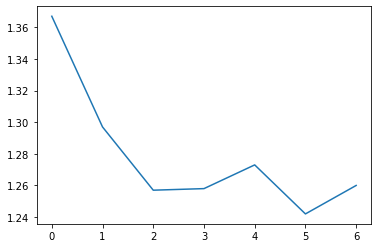

In [92]:
import random

test = x_test.reshape((-1, 7, 8))
test_idx = random.randint(0, len(x_test))
# plt.xlim(0, 10)
plt.plot(test[test_idx,:,1])

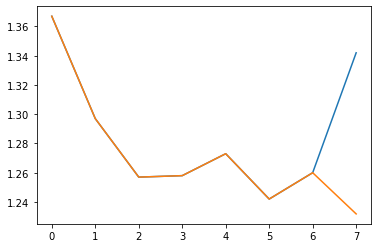

In [93]:
idxs = list(range(len(test[test_idx,:,1])))

plt.plot(idxs + [idxs[-1] + predict_offset], np.concatenate((test[test_idx,:,1], [y_test[test_idx]])))
plt.plot(idxs + [idxs[-1] + predict_offset], np.concatenate((test[test_idx,:,1], [preds[test_idx]])))

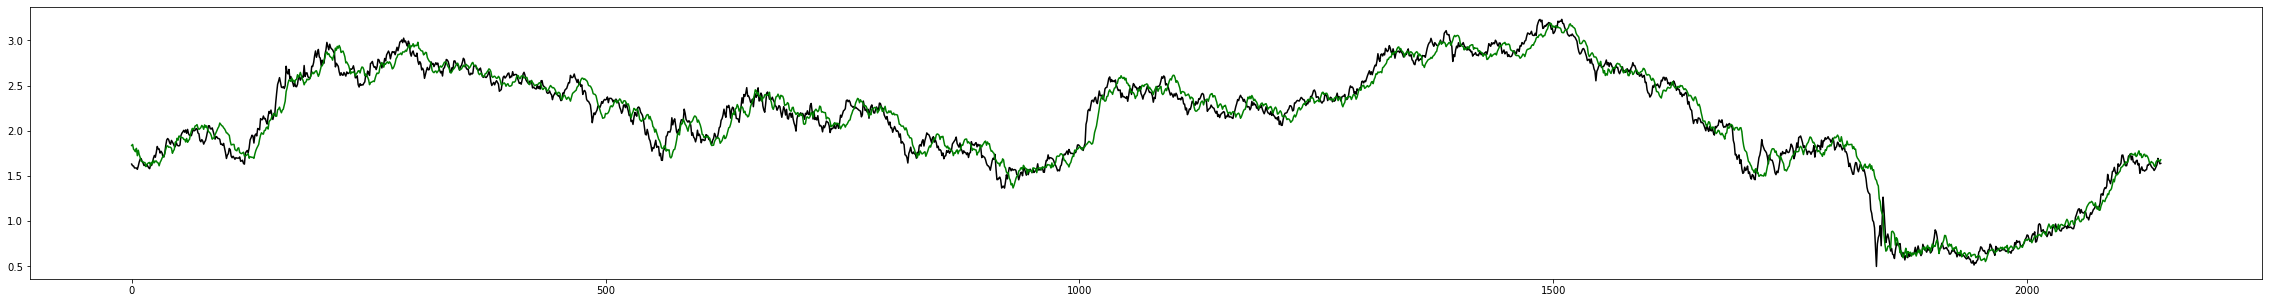

In [40]:

preds = linear_model.predict(x_train)
plt.figure(figsize=(40,5))
plt.plot(range(len(y_train)), y_train, color = 'black')
plt.plot(range(len(preds)), preds, color = 'green')
plt.show()

In [6]:
preds

array([1.63846545, 1.65595422, 1.66322408, 1.6220541 , 1.61001463,
       1.5905174 , 1.56066264, 1.61263851, 1.61076276, 1.62637149,
       1.60520974, 1.60210696, 1.62776469, 1.58207288, 1.53621871,
       1.50433879, 1.50617749, 1.45563685, 1.46717569, 1.4968467 ,
       1.49205881, 1.57152738, 1.51006088, 1.45516422, 1.49805902,
       1.47112516, 1.48721928, 1.49049031, 1.51040401, 1.49501341,
       1.45518167, 1.47475878, 1.44581982, 1.4262849 , 1.32771854,
       1.28521257, 1.3451965 , 1.3475814 , 1.35586437, 1.38500406,
       1.33408643, 1.32175717, 1.23125613, 1.18798781, 1.251837  ,
       1.29468911, 1.30851328, 1.26100227, 1.25896073, 1.27346551,
       1.27040888, 1.24152959, 1.23590665, 1.18290137, 1.17796685,
       1.18817681, 1.2586815 , 1.28189661, 1.32386029, 1.3717177 ,
       1.36094122, 1.35514653, 1.27591777, 1.23028717, 1.28128208,
       1.2402413 , 1.23422101, 1.27045911, 1.26668373, 1.31060745,
       1.3643606 , 1.34735854, 1.3127775 , 1.29516135, 1.31378

In [5]:
y_train

Date
2012-10-17    1.811
2012-10-18    1.826
2012-10-19    1.768
2012-10-22    1.798
2012-10-23    1.764
              ...  
2021-05-11    1.624
2021-05-12    1.695
2021-05-13    1.668
2021-05-14    1.635
2021-05-17    1.640
Name: Close, Length: 2156, dtype: float64

In [4]:
x_train

,Open,Previous_Close,Weekday,50SMA,100SMA,200SMA,Upper_Band,Lower_Band
Date,,,,,,,,
2012-10-17,1.755,1.720,2,1.69838,1.63014,1.809355,1.795700,1.579500
2012-10-18,1.810,1.811,3,1.70204,1.63080,1.808610,1.803096,1.575004
2012-10-19,1.799,1.826,4,1.70576,1.63175,1.807765,1.815198,1.567802
2012-10-22,1.803,1.768,0,1.70736,1.63318,1.806640,1.816579,1.567221
2012-10-23,1.775,1.798,1,1.71034,1.63535,1.805825,1.828956,1.562844
...,...,...,...,...,...,...,...,...
2021-05-11,1.604,1.602,1,1.60984,1.35727,1.052595,1.653577,1.528223
2021-05-12,1.617,1.624,2,1.61340,1.36428,1.057770,1.653736,1.528164
2021-05-13,1.690,1.695,3,1.61900,1.37203,1.063200,1.669438,1.518162


In [35]:
preds[-1]

4.05582989850223